In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm

'''
import csv
 
# opening the CSV file
with open('Langmuir waves analysis/25-04-2002/WI_H1_WAV_23030.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
 
  # displaying the contents of the CSV file
  for lines in csvFile:
        print(lines)
'''

event_start_time = dt.datetime(2002,4,25,5,56,6) # start time of the event
f2_header = 46 # 6 eV to 1113 eV 
f3_header = 51 # 200 eV to 27 keV 
f1_header = 72 # 27 keV up 
spec_header = 43

date_for_path = '25-04-2002'
path = 'Langmuir waves analysis/' + date_for_path + '/'
spec_name = 'WI_H1_WAV_23030.csv'
f2_name = 'WI_ELSP_3DP_23030.csv' # ELSP
f3_name = 'WI_EHSP_3DP_23030.csv' # EHSP
f1_name = 'WI_SFSP_3DP_23030.csv' # SFSP


def arrival_time(E):
    m = 9.1e-31
    v = np.sqrt(3.2e-16 * E/m)
    dist = 215*7e8
    t = dist/v
    return event_start_time + dt.timedelta(0,t) 

'''
#For 2002-04-25 event
spec_name = 'WI_H1_WAV_23030.csv'
f2_name = 'WI_ELSP_3DP_23030.csv' # ELSP
f3_name = 'WI_EHSP_3DP_23030.csv' # EHSP
f1_name = 'WI_SFSP_3DP_23030.csv' # SFSP
'''

"\n#For 2002-04-25 event\nspec_name = 'WI_H1_WAV_23030.csv'\nf2_name = 'WI_ELSP_3DP_23030.csv' # ELSP\nf3_name = 'WI_EHSP_3DP_23030.csv' # EHSP\nf1_name = 'WI_SFSP_3DP_23030.csv' # SFSP\n"

C:\Users\franc\AppData\Local\Temp/ipykernel_40432/1911473728.py:29: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


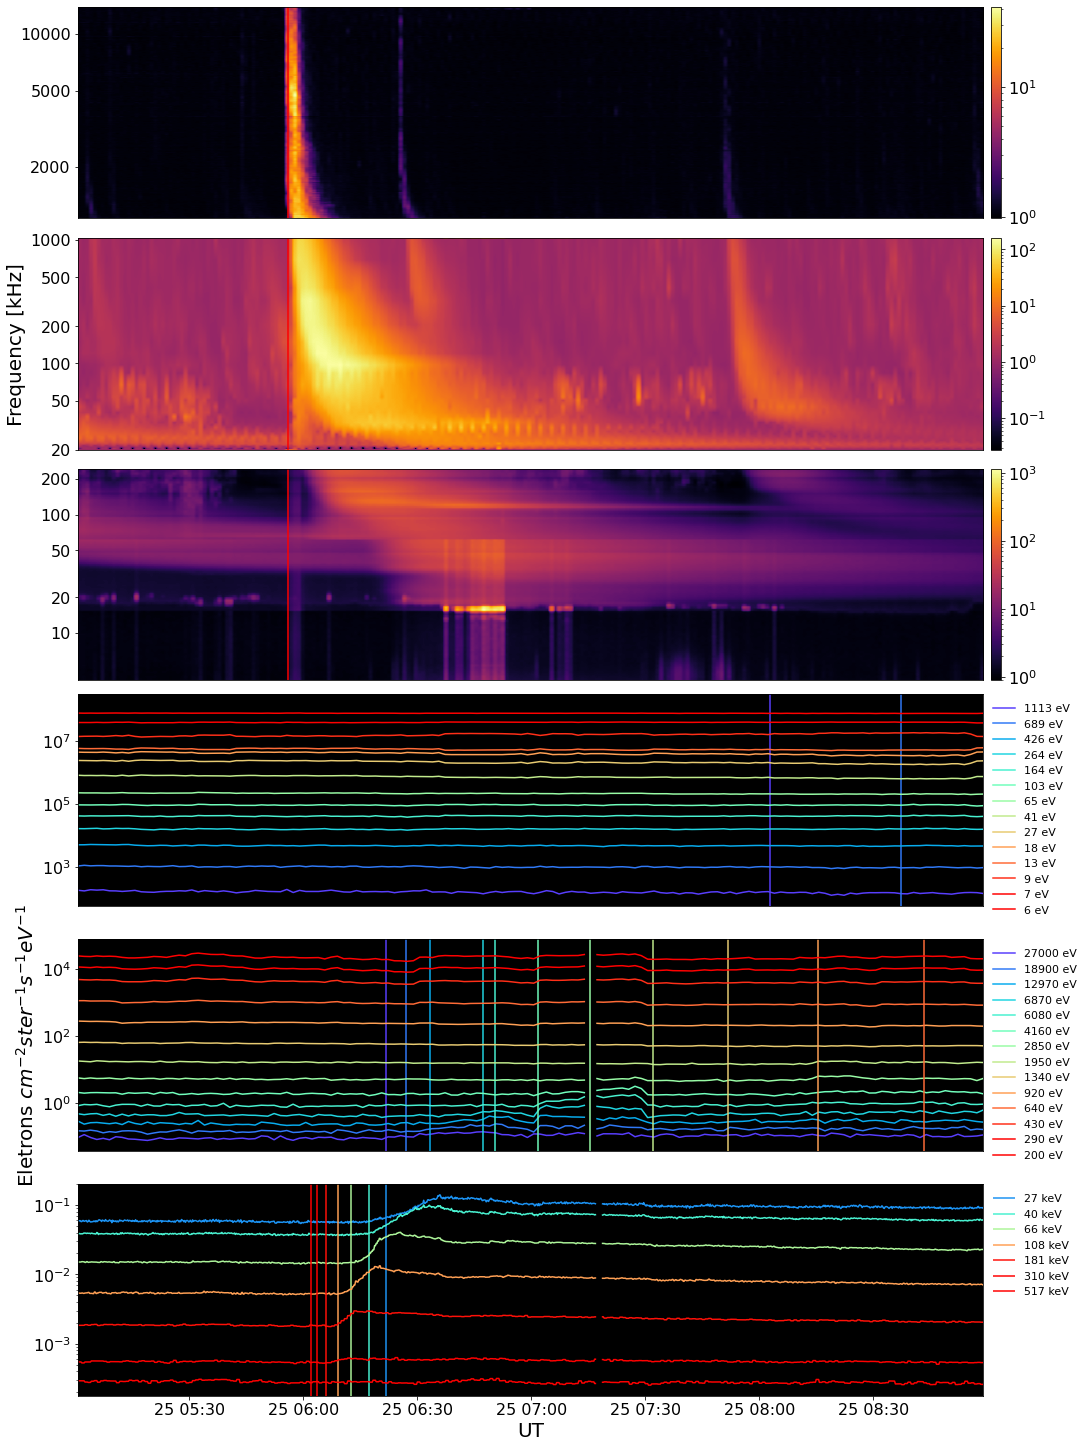

In [4]:

df_spec = pd.read_csv(path + spec_name, header=spec_header, skipfooter=3)
df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

dates_list = df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'].to_list()
x_lims_ = [dates_list[0].timestamp(), dates_list[-1].timestamp()]
x_lims = list(map(dt.datetime.fromtimestamp, x_lims_))
x_lims = mdates.date2num(x_lims)

y_lims0 = np.linspace(1075, 13825, 100)
y_lims1 = np.linspace(20, 1040, 100)
y_lims2 = np.linspace(4, 245, 100)

@plt.FuncFormatter
def fake_log(x, pos):
    'The two args are the value and tick position'
    return round(10**x) #r'$10^{%.2f}$' % (x)

df_spec = df_spec.set_index('EPOCH_yyyy-mm-ddThh:mm:ss.sssZ')
df_spec = df_spec[df_spec.columns[::-1]].T

df_spec0 = df_spec.iloc[353:-1, :]
df_spec1 = df_spec.iloc[95:353, :]
df_spec2 = df_spec.iloc[0:95, :]

date_format = mdates.DateFormatter('%H:%M:%S')
locator = mdates.HourLocator([4, 5, 6, 7, 8, 9])

fig, ax = plt.subplots(6, 1, figsize=(15,20), layout='compressed')
fig.subplots_adjust(hspace=0)

col_posit = -0.1
flare_time = dt.datetime.fromtimestamp(event_start_time.timestamp() + 3600)
flare_time = mdates.date2num(flare_time)


for a in ax:
    a.set_anchor('W')

for a in ax:
    a.patch.set_facecolor('black')

im = ax[0].imshow(df_spec0, norm=colors.LogNorm(), cmap=cm.inferno,
                  extent = [x_lims[0], x_lims[1],  np.log10(y_lims0[0]), np.log10(y_lims0[-1])], aspect='auto')
fig.colorbar(im, ax=ax[0], pad=col_posit)

ax[0].xaxis.set(major_formatter=date_format)
ax[0].tick_params(bottom = False)
ax[0].set_xticks([])
ax[0].yaxis.set_major_formatter(fake_log)
ax[0].yaxis.set_major_locator(MaxNLocator(5)) 
ax[0].set_yticks(np.log10(np.array([2000, 5000, 10000])))


im = ax[1].imshow(df_spec1, norm=colors.LogNorm(), cmap=cm.inferno,
                  extent = [x_lims[0], x_lims[1],  np.log10(y_lims1[0]), np.log10(y_lims1[-1])], aspect='auto')
fig.colorbar(im, ax=ax[1], pad=col_posit)

ax[1].xaxis.set(major_formatter=date_format)
ax[1].tick_params(bottom = False)
ax[1].set_xticks([])
ax[1].yaxis.set_major_formatter(fake_log)
ax[1].yaxis.set_major_locator(MaxNLocator(5)) 
ax[1].set_yticks(np.log10(np.array([20, 50, 100, 200, 500, 1000])))


im = ax[2].imshow(df_spec2, norm=colors.LogNorm(), cmap=cm.inferno, 
                  extent = [x_lims[0], x_lims[1],  np.log10(y_lims2[0]), np.log10(y_lims2[-1])], aspect='auto')
fig.colorbar(im, ax=ax[2], pad=col_posit)

ax[2].xaxis.set(major_formatter=date_format)
ax[2].tick_params(bottom = False)
ax[2].set_xticks([])
ax[2].yaxis.set_major_formatter(fake_log)
ax[2].yaxis.set_major_locator(MaxNLocator(5)) 
ax[2].set_yticks(np.log10(np.array([10, 20, 50, 100, 200])))

#second set of images

df1 = pd.read_csv(path + f1_name, header=f1_header, skipfooter=3)
df1['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df1['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

df2 = pd.read_csv(path + f2_name, header=f2_header, skipfooter=3)
df2['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

df3 = pd.read_csv(path + f3_name, header=f3_header, skipfooter=3)
df3['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df3['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')


i1, i2, i3 = 1, 1, 1
energies1 = [27, 40, 66, 108, 181, 310, 517]
energies2 = list(reversed(list(np.array([6, 7, 9, 13, 18, 27, 41, 65, 103, 164, 264, 426, 689, 1113])*1e-3)))
energies3 = list(reversed([0.137, 0.2, 0.29, 0.43, 0.64, 0.92, 1.34, 1.95, 2.85, 4.16, 6.08, 6.87, 12.97, 18.9, 27]))

#fig, ax = plt.subplots(3, 1, figsize=(10,10))
while i1 < 8 :
    ax[5].plot(df1.iloc[:, 0], df1.iloc[:, i1], c=cm.rainbow([50*i1]))
    ax[5].vlines(arrival_time(energies1[i1-1]), 0,0.3, color=cm.rainbow([50*i1]), label = str(energies1[i1-1]) + ' keV')
    ax[5].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
    ax[5].set_yscale("log")
    plt.gcf().autofmt_xdate()
    i1 += 1

while i2 < 15 :
    ax[3].plot(df2.iloc[:, 0], df2.iloc[:, i2], c=cm.rainbow([20*i2]), label = str(round(energies2[i2-1]*1e3)) + ' eV')
    ax[3].vlines(arrival_time(energies2[i2-1]), 0,4e8, color=cm.rainbow([20*i2]))
    ax[3].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
    ax[3].set_yscale("log")
    i2 += 1

while i3 < 15 :
    ax[4].plot(df3.iloc[:, 0], df3.iloc[:, i3], c=cm.rainbow([20*i3]), label = str(round(energies3[i3-1]*1e3)) + ' eV')
    ax[4].vlines(arrival_time(energies3[i3-1]), 0,1e5, color=cm.rainbow([20*i3]))
    ax[4].set_xlim(df3.iloc[0, 0], df3.iloc[-1, 0])
    ax[4].set_yscale("log")
    i3 += 1

ax[0].vlines(flare_time, np.log10(y_lims0[0]), np.log10(y_lims0[-1]), 'r')
ax[1].vlines(flare_time, np.log10(y_lims1[0]), np.log10(y_lims1[-1]), 'r')
ax[2].vlines(flare_time, np.log10(y_lims2[0]), np.log10(y_lims2[-1]), 'r')
ax[4].set_ylim(None, 8e4)
ax[3].set_ylim(top=3e8)
ax[5].set_ylim(top=0.2)
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[3].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize = 11, frameon=False)
ax[4].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize = 11, frameon=False)
ax[5].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize = 11, frameon=False)
ax[5].set_xlabel('UT', fontsize = 20)
ax[1].set_ylabel('Frequency [kHz]', fontsize = 20)
ax[4].set_ylabel('Eletrons $cm^{-2} ster^{-1} s^{-1} eV^{-1}$', fontsize = 20)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16)

#plt.show()
plt.savefig(path + "Spec_Plot_" + date_for_path, bbox_inches='tight')

In [3]:
'''
df_spec = pd.read_csv('Langmuir waves analysis/25-04-2002/WI_H1_WAV_23030.csv', header=43, skipfooter=3)
df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

dates_list = df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'].to_list()
x_lims_ = [dates_list[0].timestamp(), dates_list[-1].timestamp()]
x_lims = list(map(dt.datetime.fromtimestamp, x_lims_))
x_lims = mdates.date2num(x_lims)

y_lims0 = np.linspace(1075, 13825, 100)
y_lims1 = np.linspace(20, 1040, 100)
y_lims2 = np.linspace(4, 245, 100)

@plt.FuncFormatter
def fake_log(x, pos):
    'The two args are the value and tick position'
    return r'$10^{%f}$' % (x)

df_spec = df_spec.set_index('EPOCH_yyyy-mm-ddThh:mm:ss.sssZ')
df_spec = df_spec[df_spec.columns[::-1]].T

df_spec0 = df_spec.iloc[353:-1, :]
df_spec1 = df_spec.iloc[95:353, :]
df_spec2 = df_spec.iloc[0:95, :]

date_format = mdates.DateFormatter('%H:%M:%S')
locator = mdates.HourLocator([4, 5, 6, 7, 8, 9])

fig, ax = plt.subplots(3, 1, figsize=(10,7))

im = ax[0].imshow(df_spec0, norm=colors.LogNorm(), cmap=cm.inferno, extent = [x_lims[0], x_lims[1],  np.log10(y_lims0[0]), np.log10(y_lims0[-1])], aspect='auto')


ax[0].figure.colorbar(im, ax=ax[0])
ax[0].xaxis.set(major_formatter=date_format, major_locator=locator)
ax[0].tick_params(bottom = False)
ax[0].set_xticks([])
ax[0].yaxis.set_major_formatter(fake_log)
ax[0].yaxis.set_major_locator(MaxNLocator(5)) 
ax[0].set_yticks(np.log10(np.array([2000, 5000, 10000])))


im = ax[1].imshow(df_spec1, norm=colors.LogNorm(), cmap=cm.inferno, extent = [x_lims[0], x_lims[1],  np.log10(y_lims1[0]), np.log10(y_lims1[-1])], aspect='auto')


ax[1].figure.colorbar(im, ax=ax[1])
ax[1].xaxis.set(major_formatter=date_format, major_locator=locator)
ax[1].tick_params(bottom = False)
ax[1].set_xticks([])
ax[1].yaxis.set_major_formatter(fake_log)
ax[1].yaxis.set_major_locator(MaxNLocator(5)) 
ax[1].set_yticks(np.log10(np.array([20, 50, 100, 200, 500, 1000])))


im = ax[2].imshow(df_spec2, norm=colors.LogNorm(), cmap=cm.inferno, extent = [x_lims[0], x_lims[1],  np.log10(y_lims2[0]), np.log10(y_lims2[-1])], aspect='auto')


ax[2].figure.colorbar(im, ax=ax[2])
ax[2].xaxis.set(major_formatter=date_format, major_locator=locator)
ax[2].tick_params(bottom = False)
#ax[2].set_xticks([])
ax[2].yaxis.set_major_formatter(fake_log)
ax[2].yaxis.set_major_locator(MaxNLocator(5)) 
ax[2].set_yticks(np.log10(np.logspace(np.log10(5),np.log10(200),5)))

fig.autofmt_xdate()

plt.show()'''

"\ndf_spec = pd.read_csv('Langmuir waves analysis/25-04-2002/WI_H1_WAV_23030.csv', header=43, skipfooter=3)\ndf_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], format = '%Y-%m-%dT%H:%M:%S.%fZ')\n\ndates_list = df_spec['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'].to_list()\nx_lims_ = [dates_list[0].timestamp(), dates_list[-1].timestamp()]\nx_lims = list(map(dt.datetime.fromtimestamp, x_lims_))\nx_lims = mdates.date2num(x_lims)\n\ny_lims0 = np.linspace(1075, 13825, 100)\ny_lims1 = np.linspace(20, 1040, 100)\ny_lims2 = np.linspace(4, 245, 100)\n\n@plt.FuncFormatter\ndef fake_log(x, pos):\n    'The two args are the value and tick position'\n    return r'$10^{%f}$' % (x)\n\ndf_spec = df_spec.set_index('EPOCH_yyyy-mm-ddThh:mm:ss.sssZ')\ndf_spec = df_spec[df_spec.columns[::-1]].T\n\ndf_spec0 = df_spec.iloc[353:-1, :]\ndf_spec1 = df_spec.iloc[95:353, :]\ndf_spec2 = df_spec.iloc[0:95, :]\n\ndate_format = mdates.DateFormatter('%H:%M:%S')\nlocator = mdates.